In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate 
import xwmt
import xwmb
import xgcm

/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/pyproj/__init__.py:96: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))
ERROR 1: PROJ: proj_create_from_database: Open of /apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/share/proj failed
/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/pyogrio/core.py:36: RuntimeWarning: Could not detect PROJ data files.  Set PROJ_LIB environment variable to the correct path.
  _init_proj_data()


In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.9.0 
regionate version 0.5.3 
xwmt version 0.1.0 
xwmb version 0.5.3


In [5]:
ds=xr.open_dataset("SOSE_xWMB_data_kerguelen.nc")

/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/apps/jasmin/jaspy/miniforge_envs/jaspy3.12/mf3-25.3.0-3/envs/jaspy3.12-mf3-25.3.0-3-v20250704/lib/python3.12/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'gini' loading failed:
Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [6]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1, yh: 419, xq: 760, z_l: 52, xh: 759, yq: 420,
                       time_bounds: 2, z_i: 53)
Coordinates: (12/49)
  * time              (time) datetime64[ns] 8B 2013-01-02T12:00:00
  * yh                (yh) float32 2kB -70.97 -70.91 -70.86 ... -31.16 -31.02
  * xq                (xq) float32 3kB 20.0 20.17 20.33 ... 146.2 146.3 146.5
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (yh, xq) float32 1MB ...
    dxC               (yh, xq) float32 1MB ...
    ...                ...
    geolat_u          (yh, xq) float64 3MB ...
    geolon_v          (yq, xh) float64 3MB ...
    geolat_v          (yq, xh) float64 3MB ...
    lat               (yh, xh) float64 3MB ...
    lon               (yh, xh) float64 3MB ...
    maskZ             (z_l) float64 416B ...
Data variables: (12/37)
    oceFWflx          (time, yh, xh, z_l) float64 132MB ...
    THETA             (time, z_l, yh, xh) float32 66MB ...
    ADVy_TH           (time, z_l, yq, xh) float32 66MB ...
    SALT              (time, z_l, yh, xh) float32 66MB ...
    ADVy_SLT          (time, z_l, yq, xh) float32 66MB ...
    SFLUX             (time, yh, xh) float32 1MB ...
    ...                ...
    sigma2_bounds     (time_bounds, z_l, yh, xh) float64 265MB ...
    mask2D            (yh, xh) float64 3MB ...
    land              (yh, xh) bool 318kB ...
    drC_bounds        (time_bounds, z_l, yh, xh) float64 265MB ...
    SST               (time, yh, xh) float32 1MB ...
    SSS               (time, yh, xh) float32 1MB ...

In [7]:
ds["TFLUXmSW"] = ds["TFLUXmSW"]*ds.maskZ

#### Compute water mass budget

Terms in the budget are computed according to [Drake et al. (2025)](https://doi.org/10.1029/2024MS004383) for finely spaced density surfaces.

In [8]:
coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'},
        'Z': {'center': 'z_l', 'outer': 'z_i'},
    }
boundary = {'X':'extend', 'Y':'extend', 'Z':'extend'}
metrics = {('X','Y'):'rA'}

grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary=boundary, autoparse_metadata=False)
grid._ds

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1, yh: 419, xq: 760, z_l: 52, xh: 759, yq: 420,
                       time_bounds: 2, z_i: 53)
Coordinates: (12/49)
  * time              (time) datetime64[ns] 8B 2013-01-02T12:00:00
  * yh                (yh) float32 2kB -70.97 -70.91 -70.86 ... -31.16 -31.02
  * xq                (xq) float32 3kB 20.0 20.17 20.33 ... 146.2 146.3 146.5
  * z_l               (z_l) float32 208B -2.1 -6.7 -12.15 ... -5.4e+03 -5.8e+03
    dyG               (yh, xq) float32 1MB ...
    dxC               (yh, xq) float32 1MB ...
    ...                ...
    geolat_u          (yh, xq) float64 3MB ...
    geolon_v          (yq, xh) float64 3MB ...
    geolat_v          (yq, xh) float64 3MB ...
    lat               (yh, xh) float64 3MB ...
    lon               (yh, xh) float64 3MB ...
    maskZ             (z_l) float64 416B ...
Data variables: (12/37)
    oceFWflx          (time, yh, xh, z_l) float64 132MB ...
    THETA             (time, z_l, yh, xh) float32 66MB ...
    ADVy_TH           (time, z_l, yq, xh) float32 66MB ...
    SALT              (time, z_l, yh, xh) float32 66MB ...
    ADVy_SLT          (time, z_l, yq, xh) float32 66MB ...
    SFLUX             (time, yh, xh) float32 1MB ...
    ...                ...
    sigma2_bounds     (time_bounds, z_l, yh, xh) float64 265MB ...
    mask2D            (yh, xh) float64 3MB ...
    land              (yh, xh) bool 318kB ...
    drC_bounds        (time_bounds, z_l, yh, xh) float64 265MB ...
    SST               (time, yh, xh) float32 1MB ...
    SSS               (time, yh, xh) float32 1MB ...

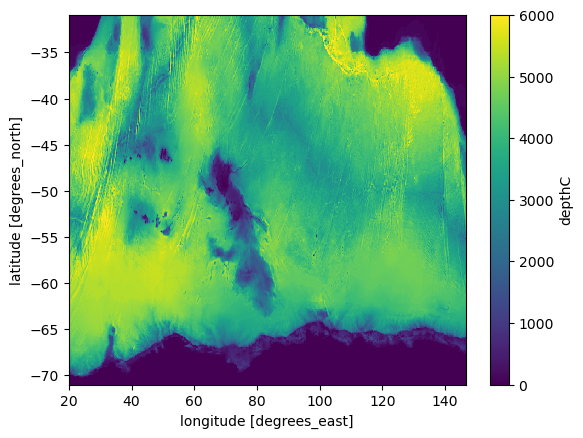

In [9]:
ds.depthC.plot()

In [10]:
# Note: the properties of this region are quite different from the rest of the Baltic!
name = "Full domain"
lons = np.array([25, 25,  140,   140])
lats = np.array([ -70,  -35,  -35,  -70])
region = regionate.GriddedRegion(name, lons, lats, grid)

plt.figure(figsize=(7,5.5))
plt.subplot(facecolor=(0.8, 0.8, 0.8))
pc = plt.pcolor(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    grid._ds['depthC'].where(grid._ds['depthC']!=0),
    cmap="Blues",
)
plt.colorbar(pc, label="depth [m]")
plt.plot(regionate.loop(region.lons), regionate.loop(region.lats), color="k");
plt.xlabel("longitude");
plt.ylabel("latitude");

DataDirError: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.

In [12]:
xbudget_dict = xbudget.load_preset_budget(model="SOSE")
xbudget_dict;

In [13]:
xbudget.collect_budgets(grid, xbudget_dict)
#xbudget_dict["mass"]

In [16]:
# specific tracer that defines the water mass
lam = "sigma2"

import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Instantiate the water mass budget class
    wmb = xwmb.WaterMassBudget(
        grid,
        xbudget_dict
    )

    wmb.mass_budget(lam, greater_than=True,default_bins=True)
    wmt = wmb.wmt.squeeze()
    wmt.load()

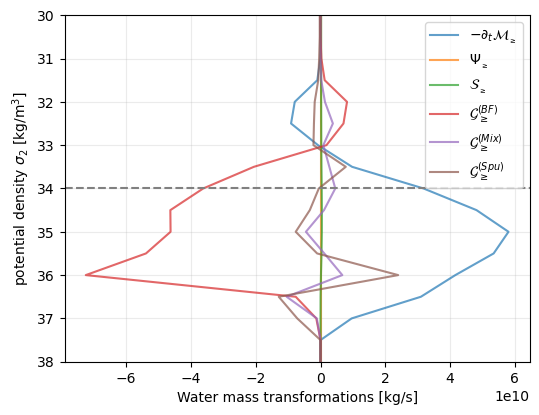

In [17]:
plt.figure(figsize=(6,4.5))

kwargs = {"alpha":0.7, "lw":1.5}

plt.plot(-wmt.mass_tendency,                wmt.sigma2_l_target, label=r"$-\partial_{t} \mathcal{M}_{_{\geq}}$",**kwargs)
plt.plot( 0.*wmt.sigma2_l_target,           wmt.sigma2_l_target, label=r"$\Psi_{_{\geq}}$",                   **kwargs)
plt.plot( wmt.mass_source,                  wmt.sigma2_l_target, label=r"$\mathcal{S}_{_{\geq}}$",            **kwargs)
plt.plot( wmt.boundary_fluxes,              wmt.sigma2_l_target, label=r"$\mathcal{G}^{(BF)}_{\geq}$",      **kwargs)
plt.plot( wmt.diffusion,                    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Mix)}_{\geq}$",     **kwargs)
plt.plot( wmt.spurious_numerical_mixing,    wmt.sigma2_l_target, label=r"$\mathcal{G}^{(Spu)}_{\geq}$", **kwargs)
plt.axhline(34, color="grey", linestyle="dashed")

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.xlabel("Water mass transformations [kg/s]")
plt.ylim(38, 30);